In [1]:
from data.unaligned_dataset import UnAlignedDataset
import numpy as np
from PIL import Image

In [2]:
dset = UnAlignedDataset("dataset/")

torch.Size([3, 128, 512]) torch.Size([3, 128, 512])


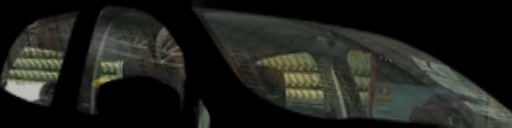

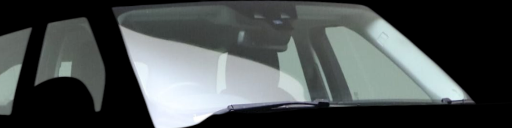

In [32]:
a,b = dset[0]
print(a.shape, b.shape)
display(Image.fromarray(np.uint8(((a+1)*127.5).permute(1,2,0).numpy())))
display(Image.fromarray(np.uint8(((b+1)*127.5).permute(1,2,0).numpy())))

In [33]:
import sagemaker
import boto3
import os
import wandb
from sagemaker.pytorch import PyTorch

In [34]:
try:
    sagemaker_session = sagemaker.Session()
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_permissions')['Role']['Arn']

Couldn't call 'get_role' to get Role ARN from role name Shivam to get Role path.


In [35]:
from datetime import datetime

bucket = "ai-sagemaker-weights"
base_job_name = "seat-gen-unpaired"
checkpoint_suffix = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
checkpoint_s3_path = "s3://ai-sagemaker-weights/seat-gen-unpaired-2022-09-06-14-13-41" #f"s3://{bucket}/{base_job_name}-{checkpoint_suffix}"
print(checkpoint_s3_path)

s3://ai-sagemaker-weights/seat-gen-unpaired-2022-09-06-14-13-41


In [36]:
source_dir = os.getcwd()
wandb.sagemaker_auth(path=source_dir)

estimator = PyTorch(entry_point='sage_train.sh',
                    source_dir=source_dir,
                    role=role,
                    py_version='py38',
                    framework_version='1.11.0',
                    base_job_name=base_job_name,
                    checkpoint_s3_uri=checkpoint_s3_path,
#                     input_mode='FastFile',
                    instance_count=1,
                    instance_type='ml.g5.2xlarge',
                    use_spot_instances=True,  # Use a spot instance
                    max_run=2*24*60*60,  # Max training time
                    max_wait=2*24*60*60,  # Max training time + spot waiting time seconds
                    hyperparameters={
                        "encoder": "seresnet18",
                        "n_epochs": 100,
                        "n_epochs_decay": 100,
                        "batch_size": 16,
                        "lr": 0.0002,
                        "n_layers_D": 3,
                        "project": "new_cut",
                        "use_wandb": True,
                        "name": "no_windows/",
                    })

In [ ]:
estimator.fit({'train': 's3://ai-sagemaker-datasets/seat_gen_unpaired_new/'}, wait=True)

2022-09-06 10:23:11 Starting - Starting the training job...
2022-09-06 10:23:34 Starting - Preparing the instances for trainingProfilerReport-1662459789: InProgress
.........
2022-09-06 10:25:14 Downloading - Downloading input data...........................
2022-09-06 10:30:44 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-09-06 10:30:47,936 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-09-06 10:30:47,957 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-09-06 10:30:47,963 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-09-06 10:30:48,932 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "train": "/opt/ml/input/data/train"
 

/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
----------------- Options ---------------
                 CUT_mode: CUT                           
              DiffAugment: False                      

/opt/conda/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[2022-09-06 10:31:21.373 algo-1:78 INFO state_store.py:115] Timestamps of different checkpoint files [('/opt/ml/checkpoints/no_windows/1_info.json', 1662459904.798126), ('/opt/ml/checkpoints/no_windows/1_netD.pth', 1662459905.154126), ('/opt/ml/checkpoints/no_windows/1_netF.pth', 1662459904.866126), ('/opt/ml/checkpoints/no_windows/1_netG.pth', 1662459906.218126), ('/opt/ml/checkpoints/no_windows/2_info.json', 1662459904.934126), ('/opt/ml/checkpoints/no_windows/2_netD.pth', 1662459905.066126), ('/opt/ml/checkpoints/no_windows/2_netF.pth', 1662459905.022126), ('/opt/ml/checkpoints/no_windows/2_netG.pth', 1662459905.958126), ('/opt/ml/checkpoints/no_windows/3_info.json', 166245990